In [1]:
import copy
import json
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from inspect_weights import load_weights
from vib_lenet_300_100_mnist import (
    VIBLeNet, MnistCsvDataset, train_test_split,
    batch_size, betas, z_dim, evaluate
)
from testing_utils import get_device
#%matplotlib widget

using device: cpu


In [2]:
torch.manual_seed(42)
device = get_device()
print(f"using device: {device}")

using device: cpu


In [3]:
with open('../weights/accuracy_data.json', 'r') as json_file:
    data = json.load(json_file)
og_acc_list = data['acc_list']

In [13]:
dataset = MnistCsvDataset("../data/mnist_data.csv")
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
print(f"train_size: {train_size}, test_size: {test_size}")

_, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

prune_perc = 0.3

weight_layers = [
    ("encoder", "0", "weight"),
    ("encoder", "2", "weight"),
    ("decoder", "weight"),
]

train_size: 56000, test_size: 14000


In [14]:
pruned_acc_list = []
for b in betas:
    model = VIBLeNet(z_dim=z_dim).to(device)
    weights = load_weights(f"../weights/vib_lenet_300_100_mnist_{b}.pth", verbose=False)
    model.load_state_dict(weights)
    original_model = copy.deepcopy(model)

    pruned_model = copy.deepcopy(original_model)
    for layer in weight_layers:
        param_name = layer[-1]
        module_path = ".".join(layer[:-1])
        module = pruned_model
        for part in module_path.split("."): module = getattr(module, part)

        prune.l1_unstructured(module, name=param_name, amount=prune_perc)

    test_loss, test_acc = evaluate(pruned_model, test_loader, device, beta=b)
    pruned_acc_list.append(test_acc)
    #print(f"pruned: {prune_perc*100:.1f}% -> test loss: {test_loss:.4f} | test acc: {test_acc:.2f}%")

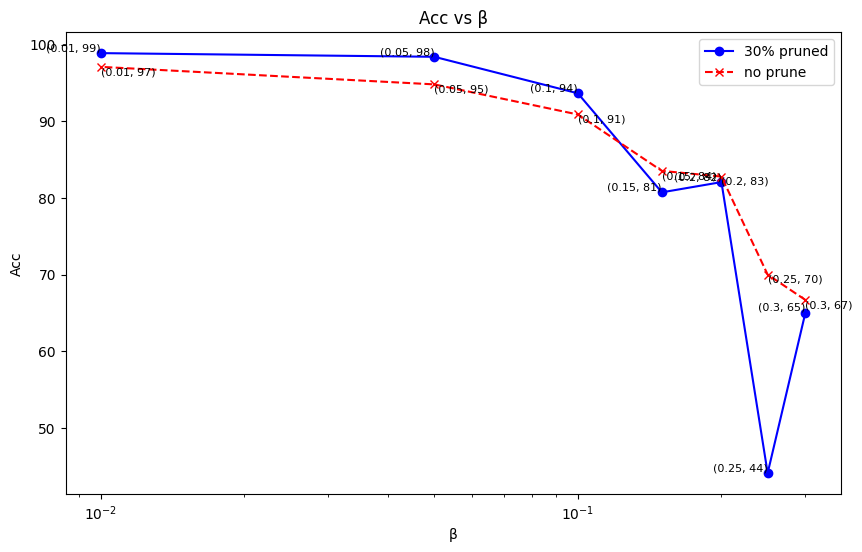

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(betas, pruned_acc_list, marker='o', linestyle='-', color='b', label=f'{prune_perc*100:.0f}% pruned')
plt.plot(betas, og_acc_list, marker='x', linestyle='--', color='r', label='no prune')

plt.xscale('log')

plt.title('Acc vs β')
plt.xlabel('β'); plt.ylabel('Acc')

for x, y in zip(betas, pruned_acc_list):
    plt.text(x, y, f"({x:.4g}, {y:.2g})", fontsize=8, 
             verticalalignment='bottom', horizontalalignment='right')

for x, y in zip(betas, og_acc_list):
    plt.text(x, y, f"({x:.4g}, {y:.2g})", fontsize=8, 
             verticalalignment='top', horizontalalignment='left')
    
plt.savefig("../plots/vib_lenet_300_100_mnist_beta_vs_pruned_acc.png", dpi=300, bbox_inches='tight')
plt.legend()
plt.show()